# Experiment for Signature Verification
Source: [SVC2004](https://www.cse.ust.hk/svc2004/)

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import math
from skimage.feature import graycomatrix, graycoprops
#%matplotlib inline
#np.set_printoptions(threshold=np.inf)

## Read Images

In [74]:
def getSignature(uid, sid) :
    if 1 <= uid <= 40 and 1 <= sid <= 40 :
        src = '../data/user{}/'+ ('genuine' if 1 <= sid <= 20 else 'forged') +'/U{}S{}.jpg'
        src = src.format(uid, uid, sid)
        return cv2.resize(cv2.imread(src, cv2.IMREAD_GRAYSCALE), (900, 600))
    else :
        return None

def getGenuineSignature(uid, sid = -1) :
    if sid == -1: sid = random.randint(1, 20)
    return getSignature(uid, sid)

def getForgedSignature(uid, sid = -1) :
    if sid == -1: sid = random.randint(21, 40)
    if sid <= 20: sid += 20
    return getSignature(uid, sid)


## Visualization

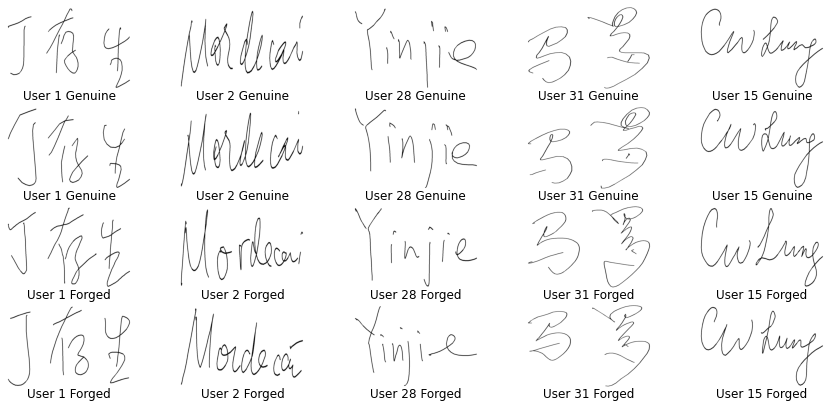

In [75]:
samples = 5
plt.figure(figsize = (15, 7))
for i in range(1, samples + 1) :
    uid = random.randint(1, 40)
    plt.subplot(4, samples, i)
    plt.axis('off')
    plt.title('User {} Genuine'.format(uid), y = -0.2)
    plt.imshow(getGenuineSignature(uid), cmap='gray')

    plt.subplot(4, samples, samples + i)
    plt.axis('off')
    plt.title('User {} Genuine'.format(uid), y = -0.2)
    plt.imshow(getGenuineSignature(uid), cmap='gray')
    
    plt.subplot(4, samples, samples * 2 + i)
    plt.axis('off')
    plt.imshow(getForgedSignature(uid), cmap='gray')
    plt.title('User {} Forged'.format(uid), y = -0.2)

    plt.subplot(4, samples, samples * 3 + i)
    plt.axis('off')
    plt.imshow(getForgedSignature(uid), cmap='gray')
    plt.title('User {} Forged'.format(uid), y = -0.2)

# Feature extraction based on GLCM

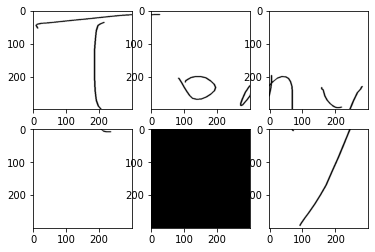

In [76]:
def getcoprops(glcm):
    return [graycoprops(glcm, 'contrast'),graycoprops(glcm, 'dissimilarity'),graycoprops(glcm,'homogeneity'),
            graycoprops(glcm,'correlation'),graycoprops(glcm,'energy'),graycoprops(glcm,'ASM')]

'''return 2 feature extraction(each with 1*120) for genuine and forged img with uid'''
'''for every image, glcm matrix is calculated (256*256*1*4). with distance 1 and 4 angle(0,45,90,135)'''
'''using the matrix, calculate the 6 properties for each angle, so totally 6*4=24 scalars for each image'''
'''apply SPM, we only use level 0 and level 1, so the total length of feature vector is 24*(4+1)=120'''
def glcm_feature(uid):
    print(uid)
    g1 = getGenuineSignature(uid)
    f1 = getForgedSignature(uid)
    
    glcm_g = graycomatrix(g1, [1], [0, np.pi/4, np.pi/2, np.pi*3/4], levels=256) #level*level*1*4
    glcm_f = graycomatrix(f1, [1], [0, np.pi/4, np.pi/2, np.pi*3/4], levels=256)
    #img=cv2.resize(img,(img_shape[1]//2,img_shape[0]//2),interpolation=cv2.INTER_CUBIC)
    genuine_prop = getcoprops(glcm_g)
    forged_prop = getcoprops(glcm_f)
    print(len(genuine_prop))
    res1 = genuine_prop[0]
    for x in genuine_prop[1:]:
        res1 = np.concatenate((res1,x),axis=1)
    res2 = forged_prop[0]
    for x in forged_prop[1:]:
        res2 = np.concatenate((res2,x),axis=1)
    
    rows = 2
    cols = 3

    cnt = 0
    for j in range(rows):
        for k in range(cols):
            cnt+=1
            img_roi = g1[(j * 300):((j + 1) * 300), (k * 450):((k + 1) * 450)]
            img_roi2 = f1[(j * 300):((j + 1) * 300), (k * 450):((k + 1) * 450)]
            plt.subplot(rows, cols, cnt)
            #cnt +=1
            plt.imshow(img_roi, cmap='gray')
            subimg1 = graycomatrix(img_roi, [1], [0, np.pi/4,np.pi/2,np.pi*3/4], levels=256)#level*level*1*4
            sub_prop1 = getcoprops(subimg1)
            for x in sub_prop1[0:]:
                res1 = np.concatenate((res1,x),axis=1)
            subimg2 = graycomatrix(img_roi2, [1], [0, np.pi/4,np.pi/2,np.pi*3/4], levels=256)#level*level*1*4
            sub_prop2 = getcoprops(subimg2)
            for x in sub_prop2[0:]:
                res2 = np.concatenate((res2,x),axis=1)
            #print(res.shape)
    print(res1,res1.shape)
    print(res2,res2.shape)
    return [res1,res2]

def getGLCMFeature(img, rows = 2, cols = 3):
    glcm = graycomatrix(img, [1], [0, np.pi/4, np.pi/2, np.pi*3/4], levels = 256) #level*level*1*4

    prop = getcoprops(glcm)
    res = prop[0]
    for x in prop[1:]:
        res = np.concatenate((res,x),axis=1)

    # cnt = 1
    dx = img.shape[1] // cols
    dy = img.shape[0] // rows
    
    for j in range(rows):
        for k in range(cols):
            img_roi = img[(j * dy):((j + 1) * dy), (k * dx):((k + 1) * dx)]
            # plt.subplot(rows, cols, cnt)
            # cnt +=1
            # plt.imshow(img_roi, cmap='gray')
            subimg = graycomatrix(img_roi, [1], [0, np.pi/4,np.pi/2,np.pi*3/4], levels=256)#level*level*1*4
            sub_prop = getcoprops(subimg)
            for x in sub_prop[0:]:
                res = np.concatenate((res,x), axis=1)
    return res

uid = random.randint(1, 40)
reference = getGenuineSignature(uid)
f_ref = getGLCMFeature(reference)
# print(f_ref.shape)

## Pre-Expreiment

### Feature Extraction

We extract feature from 1 reference genuine signature, 1 test genuine and 1 test forged signature. First, randomly pick 3 signatures of 1 user:

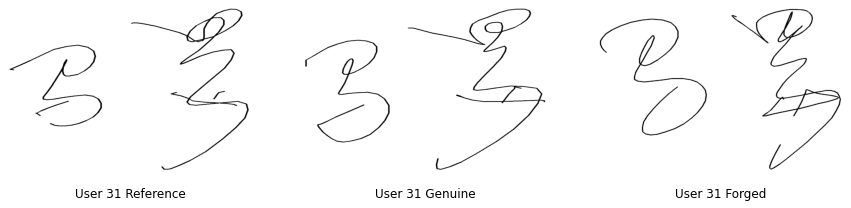

In [77]:
uid = random.randint(1, 40)
reference = getGenuineSignature(uid)
genuine = getGenuineSignature(uid)
forged = getForgedSignature(uid)

# Visualization
plt.figure(figsize = (15, 7))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('User {} Reference'.format(uid), y = -0.2)
plt.imshow(reference, cmap='gray')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('User {} Genuine'.format(uid), y = -0.2)
plt.imshow(genuine, cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('User {} Forged'.format(uid), y = -0.2)
plt.imshow(forged, cmap='gray')

## Naive Classification by Matches

Try to classify each user's signature using a Support Vector Machine.

100%|██████████| 8/8 [01:22<00:00, 10.28s/it]


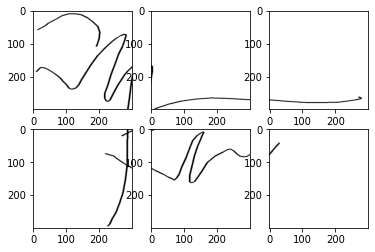

In [82]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm

x_train = []
y_train = []

for uid in tqdm(range(1, 33)):
    sid_reference = list(range(1, 21))
    random.shuffle(sid_reference)
    sid_test = random.sample(list(range(1, 41)), 20)
    for i in range(20) :
        reference = getSignature(uid, sid_reference[i])
        test = getSignature(uid, sid_test[i])
        f_ref = getGLCMFeature(reference)
        f_test = getGLCMFeature(test)
        x_train.append(np.squeeze(np.concatenate((f_ref, f_test), axis = 1)))
        y_train.append("genuine" if sid_test[i] <= 20 else "forged")

x_test = []
y_test = []
for uid in tqdm(range(33, 41)):
    sid_reference = list(range(1, 21))
    random.shuffle(sid_reference)
    sid_test = random.sample(list(range(1, 41)), 20)
    for i in range(20) :
        reference = getSignature(uid, sid_reference[i])
        test = getSignature(uid, sid_test[i])
        f_ref = getGLCMFeature(reference)
        f_test = getGLCMFeature(test)
        x_test.append(np.squeeze(np.concatenate((f_ref, f_test), axis = 1)))
        y_test.append("genuine" if sid_test[i] <= 20 else "forged")


In [79]:
#print([(xx, yy) for xx, yy in zip(x, y)][::100])

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

# x_train = np.array(x_train).reshape(-1, 1)
# x_test = np.array(x_test).reshape(-1, 1)

In [83]:
parameters = {
    'gamma': [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model = SVC(kernel='rbf')
model_grid = GridSearchCV(model, param_grid = parameters)
model_grid.fit(x_train, y_train)

model_SVM = model_grid.best_estimator_
print(model_SVM)

# model_SVM = SVC(C=1)

model_SVM.fit(x_train, y_train)
y_pred = model_SVM.predict(x_test)

print(classification_report(y_test, y_pred))

SVC(C=1, gamma=1e-06)
              precision    recall  f1-score   support

      forged       0.56      0.86      0.68        80
     genuine       0.69      0.31      0.43        80

    accuracy                           0.59       160
   macro avg       0.63      0.59      0.55       160
weighted avg       0.63      0.59      0.55       160



For verification:

['genuine', 'genuine', 'forged', 'forged']


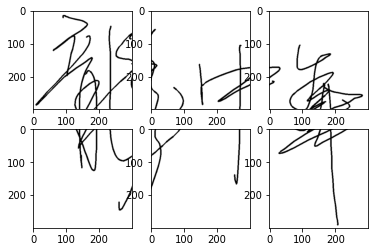

In [86]:
def verify(reference, test) :
    f_ref = getGLCMFeature(reference)
    f_test = getGLCMFeature(test)
    return model_SVM.predict(np.concatenate((f_ref, f_test), axis = 1))[0]

uid = 30
images_to_verify = [getGenuineSignature(uid), getGenuineSignature(random.randint(1, 41)),  getForgedSignature(uid), getForgedSignature(random.randint(1, 41))]
print([verify(getGenuineSignature(uid), image) for image in images_to_verify])